# Ideas

* Correlate `elapsed_time` between first case and `mandate_when` with `cases_per_million`
* Correlate `mask_mandate` with `pos_cases_per_tests`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sqlalchemy as sq
location = 'sqlite:///data/nyt_covid.db'
engine = sq.create_engine(location)
engine.table_names()

['county_covid_dates', 'county_dataset', 'county_time_dates', 'state_dataset']

In [3]:
cnx = sq.create_engine(location)
df_cdates = pd.read_sql_table('county_covid_dates', cnx, parse_dates='date')
df_county = pd.read_sql_table('county_dataset', cnx)
df_state = pd.read_sql_table('state_dataset', cnx)

# Analysis

## Covid Over Time

[Source](https://stackoverflow.com/questions/63488407/is-there-a-function-to-get-the-difference-between-two-values-on-a-pandas-datafra/63488561?noredirect=1#comment112269047_63488561) for getting resampled difference between dates using `df.resample('1W').last().diff()`.

In [4]:
df = df_cdates.set_index('date')

In [269]:
alabama_ = df[df['state']=='Alabama']['covid_cases'].reset_index()

Text(0.5, 1.0, 'Total cases in Alabama')

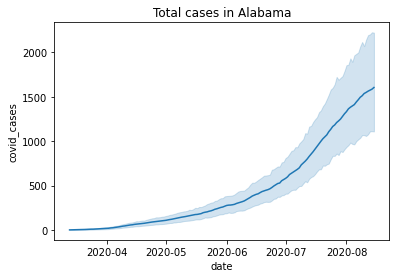

In [270]:
sns.lineplot(x='date',y='covid_cases',data=alabama_)
plt.title('Total cases in Alabama')

In [330]:
alabama_resampled_last = alabama_.resample('7D',on='date').last().diff()['covid_cases']

Text(0.5, 1.0, 'New cases in Alabama, resample last-diff method')

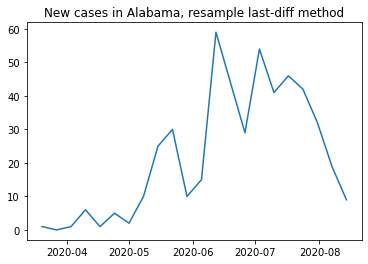

In [331]:
plt.plot(alabama_resampled_last)
plt.title('New cases in Alabama, resample last-diff method')

## County Mask Use

NOTE: Reminder that county covid cases represent the all recorded total cases in the county on August 15, 2020.

In [8]:
df_county['mask_wearer'] = (df_county['mask_always'] + df_county['mask_frequently'])*100
df_county['non_wearer'] = (df_county['mask_rarely'] + df_county['mask_never']+ df_county['mask_sometimes'])*100

In [9]:
df_county.head()

,state,region,county,division,area_type,population,covid_cases,covid_deaths,cases_per_million,cases_per_hthousand,...,intnl_migration,domestic_migration,birth_rate,death_rate,fips,sumlev,region_fips,division_fips,mask_wearer,non_wearer
0,Alabama,south,Autauga,east_south_central,county_or_equiv,55869.0,1262,23,22588.555371,2258.855537,...,-16.0,270.0,11.202671,9.712572,1001.0,50.0,3.0,6.0,73.9,26.1
1,Alabama,south,Baldwin,east_south_central,county_or_equiv,223234.0,3909,32,17510.773448,1751.077345,...,80.0,5297.0,10.446871,10.546624,1003.0,50.0,3.0,6.0,75.9,24.0
2,Alabama,south,Barbour,east_south_central,county_or_equiv,24686.0,663,6,26857.328040,2685.732804,...,13.0,-141.0,10.331329,12.591307,1005.0,50.0,3.0,6.0,69.2,30.8
3,Alabama,south,Bibb,east_south_central,county_or_equiv,22394.0,483,6,21568.277217,2156.827722,...,10.0,31.0,10.723621,11.259802,1007.0,50.0,3.0,6.0,85.0,15.0
4,Alabama,south,Blount,east_south_central,county_or_equiv,57826.0,996,5,17224.086051,1722.408605,...,6.0,59.0,11.263268,11.367077,1009.0,50.0,3.0,6.0,65.3,34.7


Text(0.5, 1.0, 'Mean of total county covid cases per thousand')

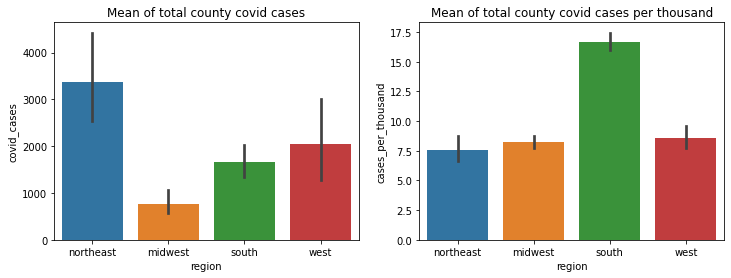

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

sns.barplot(x='region',y='covid_cases',data=df_county, order=['northeast','midwest','south','west'], ax=ax1)
ax1.set_title('Mean of total county covid cases')

sns.barplot(x='region',y='cases_per_thousand',data=df_county, order=['northeast','midwest','south','west'], ax=ax2)
ax2.set_title('Mean of total county covid cases per thousand')

__Takeaway:__ While the Northeast US has the most number of cases, the South has the greatest `cases_per_thousand` by more than 100%

To find out whether a state's citizens are wearing masks in general we performed the following:

1. Grouped `df_county` by state, aggregating `mask_wearer` columns by the mean. For the state of Alabama, for example, an average of 69% of respondents in each county responded that they "always" or "frequently" wear a mask when going outside their home.
2. We set up rules to categorize each state according to the mean of counties who answered they "always" or "frequently" wear masks outside the home: 
    * If the mean is around 70% or more, the `who_wears_masks` is set to majority. 
    * If the mean is between 50% and 70%, it is set to plurality. 
    * If the mean is between 30% and 50% the column is set to minority. 
    * If the mean is less than 30% the column is set to rarity.

This allows us to further compare states where the majority of citizens wear masks versus those that do not.

In [11]:
def mask_cat(num):
    if round(num) >= 69:
        return "majority"
    elif (round(num) > 50) & (round(num) < 69):
        return "plurality"
    elif (round(num) >= 30) & (round(num) <= 50):
        return "minority"
    else:
        return "rarity"

In [12]:
df_county['who_wears_masks'] = df_county['mask_wearer'].apply(mask_cat)

In [13]:
df_county.groupby('who_wears_masks').mean()

,population,covid_cases,covid_deaths,cases_per_million,cases_per_hthousand,cases_per_thousand,cases_per_hundred,mask_never,mask_rarely,mask_sometimes,...,intnl_migration,domestic_migration,birth_rate,death_rate,fips,sumlev,region_fips,division_fips,mask_wearer,non_wearer
who_wears_masks,,,,,,,,,,,,,,,,,,,,,
majority,154135.613555,2515.861976,73.831901,12811.467355,1281.146735,12.811467,1.281147,0.048833,0.054173,0.092831,...,279.495244,188.736623,10.716178,10.176622,30725.397422,49.964328,2.678954,5.172414,80.414930,19.583781
minority,16223.840426,156.541872,1.694581,7775.656287,777.565629,7.775656,0.777566,0.179044,0.167089,0.195236,...,8.452128,-8.856383,11.726427,10.534604,32550.724138,50.000000,2.473404,4.904255,45.869458,54.136946
plurality,28785.994030,370.859583,6.797913,11657.490998,1165.749100,11.657491,1.165749,0.114973,0.117223,0.157633,...,12.454726,26.408955,11.190999,11.043068,29349.339658,50.000000,2.591045,5.037811,61.016034,38.982922
rarity,21843.500000,69.000000,0.500000,3275.363459,327.536346,3.275363,0.327536,0.364000,0.155000,0.209000,...,-9.000000,18.000000,11.926727,12.358913,29222.000000,50.000000,2.000000,4.000000,27.200000,72.800000


Text(0.5, 1.0, 'Mean of total county cases per thousand in each region')

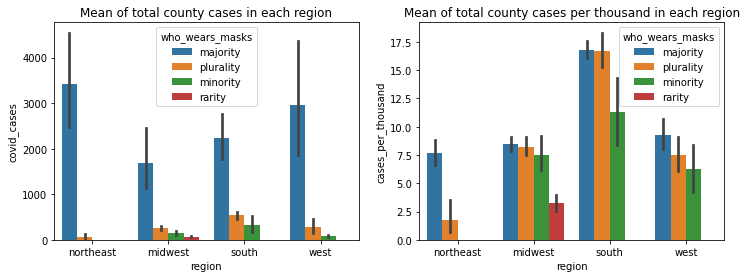

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

sns.barplot(x='region',y='covid_cases',hue='who_wears_masks', data=df_county, order=['northeast','midwest','south','west'], ax=ax1)
ax1.set_title('Mean of total county cases in each region')

sns.barplot(x='region',y='cases_per_thousand',hue='who_wears_masks', data=df_county, order=['northeast','midwest','south','west'], ax=ax2)
ax2.set_title('Mean of total county cases per thousand in each region')

__Takeaway:__ More people wear masks if the `cases_per_thousand` is higher. This may indicate that people are more likely to wear masks in the presence of urgency.

## State Mask Use

In [15]:
df_state['pop_density'] = df_state['population']/df_state['land_area_sqmi']
df_state['covid_per_density'] = df_state['covid_cases']/df_state['pop_density']

In [16]:
df_state['covid_per_sqmi'] = df_state['covid_cases']/df_state['land_area_sqmi']

In [17]:
df_graph = df_state[(df_state['state']=='Ohio')|
              (df_state['state']=='New Hampshire')|
              (df_state['state']=='Texas')|
              (df_state['state']=='Massachusetts')|
              (df_state['state']=='California')|
              (df_state['state']=='Florida')]

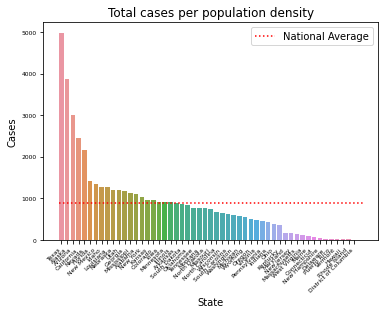

In [18]:
ax = sns.barplot(x='state',y='covid_per_density',data=df_state.sort_values('covid_per_density', ascending=False))
plt.xlabel('State')
plt.ylabel('Cases')
plt.title('Total cases per population density')
plt.xticks(rotation=45, horizontalalignment='right',)
plt.hlines(df_state['covid_per_density'].mean(),-0.5,52.5,linestyles=':',color='red',label='National Average')
plt.legend()

ax.tick_params(axis = 'both', which = 'major', labelsize = 6)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 6)

# plt.savefig('exports/all_states_avg.png',dpi=300, bbox_inches='tight')

The populations of each state differ, but the raw numbers are hard to interpret. For this reason each state is categorized into size.

Based on this boxplot the following seems reasonable:
* `small`: less than 2 million
* `medium`: 2 million - 10 million
* `large`: greater than 10 million

In [19]:
def pop_size_cat(cell):
    '''
    Categorizes each state by their size
    '''
    if pd.isnull(cell):
        return 'no data'
    elif cell < 2000000:
        return 'small'
    elif cell > 10000000:
        return 'large'
    elif (cell > 2000000) & (cell < 10000000):
        return 'medium'
    else:
        return 'no data'

In [20]:
df_state['pop_size'] = df_state['population'].apply(pop_size_cat)

In [21]:
df_state['pop_in_mill'] = df_state['population']/1000000

In [22]:
df_state.groupby('pop_size').mean()[['pop_in_mill','cases_per_million']]

,pop_in_mill,cases_per_million
pop_size,,
large,18.634202,17027.940322
medium,5.239404,15146.935926
small,1.134805,9645.262525


In [23]:
state_order = ['small','medium','large']

Text(0, 0.5, 'Total Cases')

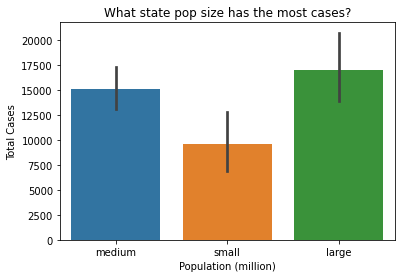

In [24]:
g = sns.barplot(x='pop_size',y='cases_per_million',data=df_state,hue_order=state_order)
#plt.hlines(df_state['non_wearer'].mean(),-0.5,3.5,linestyles='--',color='red',label='National Average')
plt.title('What state pop size has the most cases?')
plt.xlabel('Population (million)')
plt.ylabel('Total Cases')

In [25]:
# column to categorize counties is mask wearers or not
df_county['major_masks'] = df_county['mask_wearer'].apply(lambda x: 1 if x > 70 else 0)
df_county.head()

,state,region,county,division,area_type,population,covid_cases,covid_deaths,cases_per_million,cases_per_hthousand,...,birth_rate,death_rate,fips,sumlev,region_fips,division_fips,mask_wearer,non_wearer,who_wears_masks,major_masks
0,Alabama,south,Autauga,east_south_central,county_or_equiv,55869.0,1262,23,22588.555371,2258.855537,...,11.202671,9.712572,1001.0,50.0,3.0,6.0,73.9,26.1,majority,1
1,Alabama,south,Baldwin,east_south_central,county_or_equiv,223234.0,3909,32,17510.773448,1751.077345,...,10.446871,10.546624,1003.0,50.0,3.0,6.0,75.9,24.0,majority,1
2,Alabama,south,Barbour,east_south_central,county_or_equiv,24686.0,663,6,26857.328040,2685.732804,...,10.331329,12.591307,1005.0,50.0,3.0,6.0,69.2,30.8,majority,0
3,Alabama,south,Bibb,east_south_central,county_or_equiv,22394.0,483,6,21568.277217,2156.827722,...,10.723621,11.259802,1007.0,50.0,3.0,6.0,85.0,15.0,majority,1
4,Alabama,south,Blount,east_south_central,county_or_equiv,57826.0,996,5,17224.086051,1722.408605,...,11.263268,11.367077,1009.0,50.0,3.0,6.0,65.3,34.7,plurality,0


In [26]:
state_mask = df_county.groupby('state').mean()[['mask_wearer']].reset_index()
state_mask['who_wears_masks'] = state_mask['mask_wearer'].apply(mask_cat)
state_mask.head()

,state,mask_wearer,who_wears_masks
0,Alabama,69.059091,majority
1,Arizona,79.853846,majority
2,Arkansas,68.237500,plurality
3,California,86.645455,majority
4,Colorado,79.688889,majority


In [27]:
df_state_mask = df_state[['state','region','division','covid_cases','covid_deaths',
                          'covid_per_density','population','pop_density','cases_per_thousand']].merge(state_mask, on='state')
df_state_mask.head()

,state,region,division,covid_cases,covid_deaths,covid_per_density,population,pop_density,cases_per_thousand,mask_wearer,who_wears_masks
0,Alabama,south,east_south_central,107580,1896,1111.193867,4903185,96.814789,21.940840,69.059091,majority
1,Arizona,west,mountain,192670,4497,3006.870027,7278717,64.076597,26.470324,79.853846,majority
2,Arkansas,south,west_south_central,51992,600,896.480925,3017804,57.995657,17.228422,68.237500,plurality
3,California,west,pacific,621981,11229,2452.192533,39512223,253.642808,15.741483,86.645455,majority
4,Colorado,west,mountain,52868,1897,951.484016,5758736,55.563729,9.180487,79.688889,majority


In [28]:
df_state_mask['who_wears_masks'].unique()

array(['majority', 'plurality'], dtype=object)

<AxesSubplot:xlabel='who_wears_masks', ylabel='cases_per_thousand'>

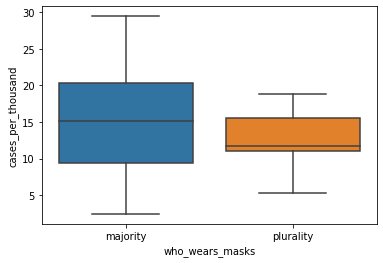

In [29]:
sns.boxplot(y='cases_per_thousand',data=df_state_mask, x='who_wears_masks')

__Takeaways:__

* Surprisingly enough, if we take the average of counties across states the majority does report to wear masks. Mask wearing varies by county, but not too much by state.
* You are also more likely to encounter people wearing masks in states where the `cases_per_thousand` is higher.

# Influence of Mask Mandates

In [42]:
df_mand = df_mand.merge(df_state_mask, on = 'state')

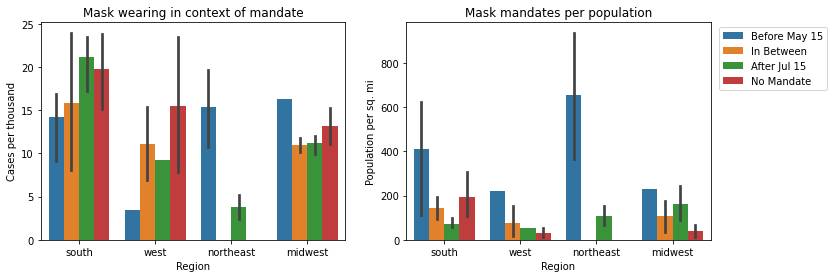

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

m = sns.barplot(x='region',y='cases_per_thousand',hue='mandate_when',data=df_mand,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'], ax=ax1)
ax1.set_title('Mask wearing in context of mandate')
ax1.set_xlabel('Region')
ax1.set_ylabel('Cases per thousand')
ax1.get_legend().remove()

m = sns.barplot(x='region',y='pop_density',hue='mandate_when',data=df_mand,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'], ax=ax2)
ax2.set_title('Mask mandates per population')
ax2.set_xlabel('Region')
ax2.set_ylabel('Population per sq. mi')
ax2.legend(bbox_to_anchor=(1.4,1))

__Interpretation:__ States who enacted mask mandates before May 15, 2020 were least hit by covid within their regions than those who mandated masks after July.  With the exception being the Northeast. States without a mandate have the highest cases of them all.

In [55]:
df_mand['deaths_per_thousand'] = (df_mand['covid_deaths']/df_mand['population']) * 1000

In [73]:
df_mand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   state                   49 non-null     object        
 1   mandate                 49 non-null     object        
 2   date                    35 non-null     datetime64[ns]
 3   type                    36 non-null     object        
 4   type_split              36 non-null     object        
 5   children_toddlers_none  49 non-null     object        
 6   month_mandate           49 non-null     object        
 7   mandate_when            49 non-null     object        
 8   region                  49 non-null     object        
 9   division                49 non-null     object        
 10  covid_cases             49 non-null     int64         
 11  covid_deaths            49 non-null     int64         
 12  covid_per_density       49 non-null     float64     

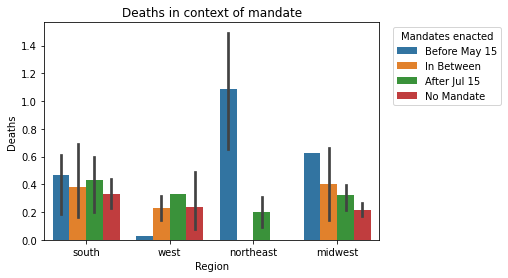

In [57]:
a = sns.barplot(x='region',y='deaths_per_thousand',hue='mandate_when',data=df_mand,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

plt.title('Deaths in context of mandate')
plt.xlabel('Region')
plt.ylabel('Deaths')

handles, labels = a.get_legend_handles_labels()
a.legend(bbox_to_anchor=(1.38,1),title='Mandates enacted',handles=handles, labels=labels)

#plt.savefig('exports/deaths_mandate.png', dpi=300, bbox_inches='tight')

__Interpretation:__ Mandates went into effect as a reactionary measure.

Text(0, 0.5, 'Positive cases per thousand')

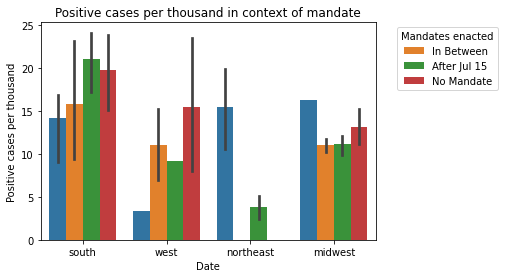

In [60]:
o = sns.barplot(x='region',y='cases_per_thousand',hue='mandate_when',data=df_mand,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

handles, labels = o.get_legend_handles_labels()
o.legend(bbox_to_anchor=(1.38,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

plt.title('Positive cases per thousand in context of mandate')
plt.xlabel('Date')
plt.ylabel('Positive cases per thousand')

# plt.savefig('exports/cases_madate.png', dpi=300, bbox_inches='tight')

In [61]:
month_map = {
    1:'Jan',
    2:'Feb',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'Aug',
    9:'Sept',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}

In [63]:
df_mand['month_case'] = df_mand['date'].dt.month

In [64]:
df_mand['month_case_name'] = df_mand['month_case'].map(month_map)

In [87]:
df_cat_graph = df_mand[df_mand['month_case'] >= 1]

In [89]:
df_cat_graph = df_cat_graph.groupby('state').mean().reset_index()
df_cat_graph['pop_size'] = df_cat_graph['population'].map(pop_size_cat)
df_cat_graph = df_cat_graph.merge(df_mand[['state','mandate_when']],on='state')
df_cat_graph['month_case_name'] = df_cat_graph['month_case'].map(month_map)

Text(0.5, 0, 'Date of Mask Mandate')

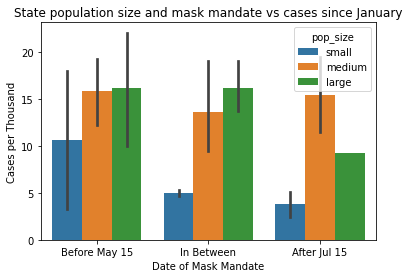

In [90]:
sns.barplot(x='mandate_when',y='cases_per_thousand',hue='pop_size',
            data=df_cat_graph, hue_order=state_order, 
            order=[
                'Before May 15',
                'In Between',
                'After Jul 15'
            ])
plt.title('State population size and mask mandate vs cases since January')
plt.ylabel('Cases per Thousand')
plt.xlabel('Date of Mask Mandate')

__Interpretation:__ More evidence that mandates were reactionary with some additional insights: 

* States with a small population size who enacted mandates before May had more cases per thousand at the time than states of similar size who enacted mask mandates afterwards.
* The same is true of medium, but not large, states
* This indicates that smaller states are learning from each other